基于经典网络架构实现图像分类模型

![](images/3.png)

In [35]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models, datasets

import imageio
import time
import warnings
import random
import sys
import copy
import json
from PIL import Image

数据读取与预处理操作

In [36]:
data_dir = './data/flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

Data Augmentation

In [37]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45), # 数据增强，随机旋转 -45 ~ 45 deg
        transforms.CenterCrop(224), # 从中心开始裁剪 1024->resize 256->crop 224
        transforms.RandomHorizontalFlip(p=0.5), # 一定概率水平翻转
        transforms.RandomVerticalFlip(p=0.5), # 随机垂直翻转
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1), # 亮度、对比度、饱和度、色相
        transforms.RandomGrayscale(p=0.025), # 概率转换成灰度图，3通道就是 R = G = B
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406] , [0.229, 0.224, 0.225]) # 减去均值，比上标准差 refer to ImageNet
    ]),
    'valid': transforms.Compose([ # 验证集不需要数据增强
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406] , [0.229, 0.224, 0.225]) # Normalize 需要和训练集的相同
    ])
}

In [38]:
batch_size = 8

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        data_transforms[x]
    ) for x in ['train', 'valid'] # 分别获得 image_datasets['train'], image_datasets['valid']
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x],
        batch_size=batch_size,
        shuffle=True
    ) for x in ['train', 'valid']
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in ['train', 'valid']
}

class_names = image_datasets['train'].classes

In [39]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 1
     Root location: ./data/flower_data\train
     StandardTransform
 Transform: Compose(
                RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
                CenterCrop(size=(224, 224))
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                ColorJitter(brightness=[0.8, 1.2], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
                RandomGrayscale(p=0.025)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 1
     Root location: ./data/flower_data\valid
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0

In [40]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1d3003b7fd0>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x1d3003b7490>}

In [41]:
dataset_sizes

{'train': 1, 'valid': 1}

读取标签对应的实际名字

In [42]:
with open('data/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [43]:
cat_to_name

{'1': 'helloworld'}

In [44]:
def im_convert(tensor):
    image= tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0) # c, h, w -> h, w, c
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1) # 把小于min的数全部置换为min，大于max的数全部置换为max，在[min,max]之间的数则不变

    return image

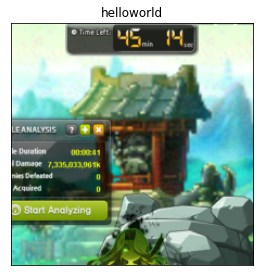

In [45]:
fig = plt.figure(figsize=(20, 12))

dataiter = iter(dataloaders['valid'])
inputs, classes = dataiter.next()
idx = 0
columns = 4
rows = 2

ax = fig.add_subplot(rows, columns, idx + 1, xticks=[], yticks=[])
ax.set_title(cat_to_name[str(int(class_names[classes[idx]]))])
plt.imshow(im_convert(inputs[idx]))

plt.show()

加载 models 中提供的模型，并且直接使用训练好的权重当作初始化参数

In [46]:
model_name = 'resnet' # ['resnet', 'alexnet', 'vgg', ...]
# 是否使用人家训练好的特征
feature_extract = True

In [47]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print("CUDA is available! Training on GPU ...")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA is not available. Training on CPU ...


In [48]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [49]:
model_ft = models.resnet152()
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [50]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = models.resnet152(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(
        nn.Linear(num_ftrs, num_classes), # 1024 个分类 迁移-> 102 个分类
        nn.LogSoftmax(dim=1)
    )
    input_size = 224

    return model_ft, input_size

设置哪些层需要训练

In [51]:
model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True)

model_ft = model_ft.to(device)

filename = 'checkpoint.pth'

# 是否训练所有层
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print('\t', name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print('\t', name)


Params to learn:
	 fc.0.weight
	 fc.0.bias


In [52]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

优化器设置

In [53]:
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)
# 学习率每 7 个 epoch 衰减为原来的 1 / 10
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# 最后一层已经 LogSoftmax 了，所以不能 nn.CrossEntropyLoss() 来计算
# nn.CrossEntropyLoss() 相当于 LogSoftmax 和 nn.NLLLoss 的整合
criterion = nn.NLLLoss()

训练模块

In [54]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5,
                is_inception=False, filename=filename):
    since = time.time()
    best_acc = 0 # 最好准确率

    model.to(device)

    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    LRs = [optimizer.param_groups[0]['lr']]

    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 训练和验证
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]: # every batch
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    else: # resnet 执行这里
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1) # preds 是每一行最大元素索引

                    # 训练时更新权重
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 计算损失
                running_loss += loss.item() * inputs.size(0) # loss(double) 乘上 batch 的数据个数 torch.Size([1, 3, 244, 244, 244])
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset) # 最后结果要除以总数据个数
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset) # 最后结果要除以总数据个数 <= 1.0

            time_elapsed = time.time() - since
            print('Time elapsed: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # 得到最好的模型
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                    'state_dict': model.state_dict(),
                    'best_acc': best_acc,
                    'optimizer': optimizer.state_dict()
                }
                torch.save(state, filename)

            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                scheduler.step() # 调整学习率
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)

        print('Optimizer learning rate: {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    # 训练完后用最好的一次当作模型最终结果
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs


In [55]:
model_ft, val_acc_history, train_acc_history, \
    valid_losses, train_losses, LRs = train_model(
    model_ft,
    dataloaders,
    criterion,
    optimizer_ft,
    num_epochs=5,
    is_inception=False,
    filename=filename
)

Epoch 0/4
----------
Time elapsed: 0m 2s
train Loss: 4.5648 Acc: 0.0000
Time elapsed: 0m 2s
valid Loss: 0.0000 Acc: 1.0000
Optimizer learning rate: 0.0100000

Epoch 1/4
----------
Time elapsed: 0m 4s
train Loss: 0.0000 Acc: 1.0000
Time elapsed: 0m 5s
valid Loss: 0.0000 Acc: 1.0000
Optimizer learning rate: 0.0100000

Epoch 2/4
----------
Time elapsed: 0m 5s
train Loss: 0.0000 Acc: 1.0000
Time elapsed: 0m 6s
valid Loss: 0.0000 Acc: 1.0000
Optimizer learning rate: 0.0100000

Epoch 3/4
----------
Time elapsed: 0m 6s
train Loss: 0.0000 Acc: 1.0000
Time elapsed: 0m 7s
valid Loss: 0.0000 Acc: 1.0000
Optimizer learning rate: 0.0100000

Epoch 4/4
----------
Time elapsed: 0m 8s
train Loss: 0.0000 Acc: 1.0000
Time elapsed: 0m 8s
valid Loss: 0.0000 Acc: 1.0000
Optimizer learning rate: 0.0100000

Training complete in 0m 8s
Best val Acc: 1.0000


再继续训练所有层：

In [56]:
for param in model_ft.parameters():
    param.requires_grad = True

# 再继续训练所有的参数，学习率调小一点
optimizer = optim.Adam(model_ft.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 损失函数
criterion = nn.NLLLoss()

In [57]:
# load checkpoint
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [58]:
model_ft, val_acc_history, train_acc_history, \
    valid_losses, train_losses, LRs = train_model(
    model_ft,
    dataloaders,
    criterion,
    optimizer_ft,
    num_epochs=5,
    is_inception=False,
    filename=filename
)

Epoch 0/4
----------
Time elapsed: 0m 2s
train Loss: 0.0000 Acc: 1.0000
Time elapsed: 0m 3s
valid Loss: 0.0000 Acc: 1.0000
Optimizer learning rate: 0.0100000

Epoch 1/4
----------
Time elapsed: 0m 6s
train Loss: 0.0000 Acc: 1.0000
Time elapsed: 0m 6s
valid Loss: 0.0000 Acc: 1.0000
Optimizer learning rate: 0.0100000

Epoch 2/4
----------
Time elapsed: 0m 10s
train Loss: 0.0000 Acc: 1.0000
Time elapsed: 0m 11s
valid Loss: 0.0000 Acc: 1.0000
Optimizer learning rate: 0.0100000

Epoch 3/4
----------
Time elapsed: 0m 14s
train Loss: 0.0000 Acc: 1.0000
Time elapsed: 0m 15s
valid Loss: 0.0000 Acc: 1.0000
Optimizer learning rate: 0.0100000

Epoch 4/4
----------
Time elapsed: 0m 17s
train Loss: 0.0000 Acc: 1.0000
Time elapsed: 0m 18s
valid Loss: 0.0000 Acc: 1.0000
Optimizer learning rate: 0.0100000

Training complete in 0m 18s
Best val Acc: 1.0000


加载训练好的模型

In [59]:
model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True)

model_ft = model_ft.to(device)

filename = 'checkpoint.pth'

# load checkpoint
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

测试数据预处理

In [60]:
def process_image(image_path):
    img = Image.open(image_path)

    # Resize 256 * 256
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))

    # Crop 操作
    left_margin = (img.width - 224) / 2
    bottom_margin = (img.height - 224) / 2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin, top_margin))

    # 相同的处理方法
    img = np.array(img) / 255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img - mean) / std

    # 颜色通道放在第一个位置
    img = img.transpose((2, 0, 1))

    return img

In [61]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()

    # 颜色通道还原：
    image = np.array(image).transpose((1, 2, 0))

    # 预处理还原：
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = image.clip(0, 1)

    ax.imshow(image)
    ax.set_title(title)

    return ax

<AxesSubplot:>

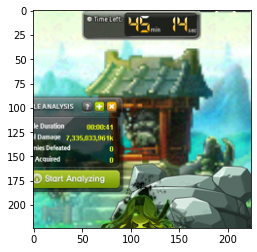

In [62]:
img_path = 'data/flower_data/train/1/BA.png'

img = process_image(img_path)
imshow(img)

In [63]:
img.shape

(3, 224, 224)

In [65]:
dataiter = iter(dataloaders['valid'])
images, labels = dataiter.next()

model_ft.eval()

if train_on_gpu:
    output = model_ft((images.cuda))
else:
    output = model_ft(images)

In [66]:
output.shape

torch.Size([1, 102])

In [68]:
_, preds = torch.max(output, 1)

preds = np.squeeze()

tensor([0])